# Requerimiento 3: Análisis de Frecuencia de Palabras

## Descripción del Requerimiento

Este notebook implementa un **análisis de frecuencia de palabras** para identificar los términos más relevantes en la literatura científica sobre Inteligencia Artificial Generativa.

### Objetivos:
1. Extraer abstracts de un archivo BibTeX consolidado
2. Limpiar y preprocesar el texto eliminando stopwords y caracteres especiales
3. Analizar frecuencias de palabras clave específicas de la categoría
4. Identificar términos emergentes mediante análisis de frecuencias globales
5. Visualizar resultados con gráficos comparativos

### Metodología:

**Palabras Clave de la Categoría**:
Se analizan 15 términos específicos relacionados con IA Generativa:
- **Técnicas**: generative models, prompting, machine learning, fine-tuning
- **Aspectos éticos**: algorithmic bias, explainability, transparency, ethics, privacy
- **Interacción**: human-ai interaction, ai literacy, co-creation, personalization
- **Datos**: training data, multimodality

**Métricas Calculadas**:
1. Frecuencia absoluta de cada término
2. Top 15 palabras globales más frecuentes
3. Precisión: porcentaje de coincidencia entre palabras top y categoría predefinida

### Importaciones y Configuración Inicial

Esta sección descarga los recursos necesarios de NLTK para el procesamiento de lenguaje natural.

#### Recursos de NLTK Descargados:

**1. punkt**
- **Función**: Tokenizador de oraciones y palabras
- **Uso**: Divide el texto en tokens (palabras individuales)
- **Algoritmo**: Unsupervised sentence boundary detection

**2. stopwords**
- **Función**: Lista de palabras comunes sin valor semántico
- **Ejemplos**: the, and, is, are, was, were, in, on, at, to, from
- **Uso**: Filtrar palabras que no aportan significado al análisis

**3. punkt_tab**
- **Función**: Datos tabulares para el tokenizador Punkt
- **Uso**: Mejora la precisión de la tokenización

#### Descarga Automática:

```python
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
```

La primera ejecución descargará los recursos. Ejecuciones posteriores detectarán que ya están instalados.

In [1]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /home/nop/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/nop/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/nop/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

### Carga del Archivo BibTeX

Esta celda realiza la extracción de abstracts del archivo bibliográfico consolidado.

#### Proceso de Carga:

**1. Configuración de Variables de Entorno**
```python
from dotenv import load_dotenv
load_dotenv()
```
- Carga variables de entorno desde archivo `.env`
- Separa configuración del código
- Evita hardcodear rutas

**2. Obtención de Ruta del Archivo**
```python
ruta_bib = os.getenv("CONSOLIDADO_PATH", "consolidado.bib")
```
- Variable `CONSOLIDADO_PATH` en archivo `.env`
- Fallback a `"consolidado.bib"` si no existe la variable
- Permite cambiar la ruta sin modificar código

**3. Verificación de Existencia**
```python
if not os.path.exists(ruta_bib):
    raise FileNotFoundError(f"No se encuentra {ruta_bib}")
```
- Verifica que el archivo existe antes de abrirlo
- Falla rápido con mensaje claro

**4. Apertura del Archivo**
```python
with open(ruta_bib, encoding="utf-8") as bibtex_file:
```
- Encoding UTF-8 para soportar caracteres especiales
- Context manager asegura cierre automático

**5. Parsing con bibtexparser**
```python
bib_database = bibtexparser.load(bibtex_file)
```
- Convierte el archivo BibTeX a estructura Python
- Cada entrada es un diccionario con campos bibliográficos

**6. Extracción de Abstracts**
```python
for entry in bib_database.entries:
    if "abstract" in entry:
        abstracts.append(entry["abstract"])
```
- Itera sobre todas las entradas
- Verifica existencia del campo `abstract`
- Almacena solo abstracts válidos

#### Configuración del Archivo `.env`:

```bash
CONSOLIDADO_PATH=/ruta/completa/al/archivo/consolidado.bib
```

### Lectura del Documento BibTeX

In [2]:
import bibtexparser
import os
from dotenv import load_dotenv

# Cargar variables de entorno
load_dotenv()

# Obtener ruta del archivo consolidado desde variable de entorno
ruta_bib = os.getenv("CONSOLIDADO_PATH", "consolidado.bib")

# Verificar que el archivo existe
if not os.path.exists(ruta_bib):
    print(f"Error: No se encuentra el archivo en {ruta_bib}")
    raise FileNotFoundError(f"No se encuentra {ruta_bib}")

print(f"Leyendo archivo: {ruta_bib}")

# Cargar el archivo BibTeX
with open(ruta_bib, encoding="utf-8") as bibtex_file:
    bib_database = bibtexparser.load(bibtex_file)

# Extraer los abstracts de cada entrada
abstracts = []
for entry in bib_database.entries:
    if "abstract" in entry:
        abstracts.append(entry["abstract"])

print(f"Se encontraron {len(abstracts)} abstracts en el archivo.")

Leyendo archivo: /home/nop/Documentos/proyectoAnalisisAlgoritmos/proyecto/salidas/consolidado.bib
Se encontraron 3368 abstracts en el archivo.


### Preprocesamiento y Limpieza de Texto

Esta celda implementa un pipeline completo de limpieza y normalización del texto para análisis de frecuencias.

#### Pipeline de Procesamiento:

**Paso 1: Unificación y Normalización**
```python
texto = " ".join(abstracts).lower()
```
- Combina todos los abstracts en un único texto
- Convierte a minúsculas para normalización
- Evita contar "AI", "ai", "Ai" como palabras diferentes

**Paso 2: Eliminación de Caracteres Especiales**
```python
texto = re.sub(r'[^a-z\s]', '', texto)
```
- Regex `[^a-z\s]` = todo lo que NO sea letra (a-z) o espacio
- Elimina números, puntuación, símbolos y caracteres especiales

**Ejemplo de transformación**:
```
Original: "AI-powered systems (2024) achieve 95% accuracy!"
Limpio:   "ai powered systems  achieve  accuracy"
```

**Paso 3: Tokenización**
```python
tokens = word_tokenize(texto)
```
- Divide el texto en palabras individuales (tokens)
- Algoritmo: NLTK Punkt tokenizer
- Maneja espacios múltiples y contracciones

**Paso 4: Filtrado de Stopwords y Palabras Cortas**
```python
stop_words = set(stopwords.words("english"))
tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
```

**Criterios de filtrado**:
1. **Stopwords**: Palabras comunes sin valor semántico (the, and, is, are...)
2. **Palabras cortas** (≤ 2 caracteres): Artículos, preposiciones, pronombres

**Ejemplo de filtrado**:
```
Antes:  ["the", "machine", "learning", "model", "is", "a", "generative", "ai", "system"]
Después: ["machine", "learning", "model", "generative", "system"]
```

#### Beneficios del Preprocesamiento:

- Normalización: todas las palabras en formato estándar
- Reducción de ruido: elimina información irrelevante
- Enfoque semántico: mantiene solo palabras con significado
- Eficiencia: reduce el tamaño del dataset

In [3]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Unir todos los abstracts en un solo texto
texto = " ".join(abstracts).lower()

# Eliminar caracteres especiales y números
texto = re.sub(r'[^a-z\s]', '', texto)

# Tokenizar
tokens = word_tokenize(texto)

# Eliminar stopwords en inglés y palabras muy cortas
stop_words = set(stopwords.words("english"))
tokens = [word for word in tokens if word not in stop_words and len(word) > 2]

print(f"Cantidad total de tokens limpios: {len(tokens)}")
print("Ejemplo de tokens:", tokens[:20])

Cantidad total de tokens limpios: 398402
Ejemplo de tokens: ['artificial', 'intelligence', 'transformed', 'data', 'science', 'enabling', 'advanced', 'solutions', 'data', 'processing', 'predictive', 'modeling', 'decisionmaking', 'paper', 'explores', 'cuttingedge', 'applications', 'algorithms', 'including', 'deep']


### Conteo de Frecuencias de Palabras Clave

### Análisis de Frecuencias de Palabras Clave

Esta celda analiza la frecuencia de aparición de términos específicos relacionados con IA Generativa.

#### Lista de Palabras Clave de la Categoría:

Las 15 palabras/frases se agrupan en categorías temáticas:

**Técnicas y Modelos**:
- generative models
- prompting
- machine learning
- multimodality
- fine-tuning

**Datos y Entrenamiento**:
- training data

**Ética y Responsabilidad**:
- algorithmic bias
- explainability
- transparency
- ethics
- privacy

**Interacción Humano-IA**:
- personalization
- human-ai interaction
- ai literacy

**Colaboración**:
- co-creation

#### Metodología de Conteo:

**Preparación del Texto**:
```python
tokens_unidos = " ".join(tokens)
```
- Une los tokens para buscar frases completas
- Permite detectar términos multi-palabra como "machine learning"

**Búsqueda con Expresiones Regulares**:
```python
palabra_limpia = palabra.lower().replace("-", " ")
count = len(re.findall(r'\b' + re.escape(palabra_limpia) + r'\b', tokens_unidos))
```

**Componentes del regex**:
- `\b`: Word boundary (límite de palabra) - asegura coincidencias exactas
- `re.escape()`: Escapa caracteres especiales
- `r'\b...\b'`: Raw string para regex

**Ejemplo de búsqueda**:
```python
texto = "machine learning models use machine learning algorithms"
matches = re.findall(r'\bmachine learning\b', texto)
# Resultado: 2 coincidencias
```

In [4]:
palabras_categoria = [
    "generative models", "prompting", "machine learning", "multimodality",
    "fine-tuning", "training data", "algorithmic bias", "explainability",
    "transparency", "ethics", "privacy", "personalization",
    "human-ai interaction", "ai literacy", "co-creation"
]

# Unir tokens en una cadena para buscar frases completas
tokens_unidos = " ".join(tokens)
frecuencias_categoria = {}

for palabra in palabras_categoria:
    palabra_limpia = palabra.lower().replace("-", " ")
    count = len(re.findall(r'\b' + re.escape(palabra_limpia) + r'\b', tokens_unidos))
    frecuencias_categoria[palabra] = count

print("=== Frecuencia de palabras de la categoría ===")
for palabra, freq in frecuencias_categoria.items():
    print(f"{palabra}: {freq}")


=== Frecuencia de palabras de la categoría ===
generative models: 239
prompting: 41
machine learning: 636
multimodality: 8
fine-tuning: 2
training data: 92
algorithmic bias: 48
explainability: 67
transparency: 183
ethics: 149
privacy: 395
personalization: 62
human-ai interaction: 0
ai literacy: 0
co-creation: 0


### Análisis de Palabras Más Frecuentes

### Análisis de Palabras Más Frecuentes y Cálculo de Precisión

Esta celda identifica las palabras más comunes en el corpus y evalúa su relación con las palabras clave predefinidas.

#### Proceso de Análisis:

**1. Conteo de Frecuencias Globales**
```python
frecuencias_globales = Counter(tokens)
```
- Counter: estructura de datos eficiente de `collections`
- Complejidad: O(n) para contar
- Resultado: diccionario con todas las palabras y sus frecuencias

**2. Extracción del Top 15**
```python
top15 = frecuencias_globales.most_common(15)
```
- most_common(n): retorna las n palabras más frecuentes
- Formato: lista de tuplas `[(palabra, frecuencia), ...]`
- Ordenamiento: descendente por frecuencia

**3. Cálculo de Precisión**
```python
palabras_top = [p for p, _ in top15]
coincidencias = [p for p in palabras_top if any(p in pc for pc in palabras_categoria)]
precision = len(coincidencias) / len(palabras_top) * 100
```

**Métrica: Precisión**
```
Precisión = (Palabras Top que están en Categoría) / (Total Palabras Top) × 100
```

**Interpretación**:
- Alta precisión (>70%): Las palabras clave predefinidas son muy representativas
- Media precisión (30-70%): Hay términos relevantes no considerados
- Baja precisión (<30%): Las palabras clave no capturan el vocabulario dominante

#### Análisis de Coincidencias:

El análisis compara las palabras más frecuentes del corpus con las palabras clave predefinidas para evaluar qué tan bien la categoría captura el vocabulario dominante.

**Palabras que pueden coincidir**:
- Términos completos: "machine learning", "privacy", "ethics"
- Palabras individuales: "data" (de "training data"), "learning" (de "machine learning")
- Variaciones: "model" vs "models", "generative"

In [5]:
from collections import Counter

# Calcular las palabras más frecuentes
frecuencias_globales = Counter(tokens)
top15 = frecuencias_globales.most_common(15)

# Comparar con las palabras originales
palabras_top = [p for p, _ in top15]
coincidencias = [p for p in palabras_top if any(p in pc for pc in palabras_categoria)]
precision = len(coincidencias) / len(palabras_top) * 100

print("\n=== Top 15 palabras más frecuentes ===")
for palabra, freq in top15:
    print(f"{palabra}: {freq}")

print(f"\nPrecisión de palabras nuevas respecto a las originales: {precision:.2f}%")
print(f"Coincidencias encontradas: {coincidencias}")



=== Top 15 palabras más frecuentes ===
artificial: 3877
intelligence: 3856
generative: 3811
data: 3273
learning: 2804
research: 2518
study: 2320
models: 2146
model: 1696
potential: 1634
challenges: 1573
using: 1505
development: 1486
paper: 1458
applications: 1397

Precisión de palabras nuevas respecto a las originales: 33.33%
Coincidencias encontradas: ['generative', 'data', 'learning', 'models', 'model']


### Exportación de Resultados a CSV

Esta celda exporta los resultados del análisis de frecuencias a archivos CSV para facilitar su uso en otras herramientas.

#### Archivos Generados:

**1. frecuencias_palabras_categoria.csv**
- **Contenido**: Frecuencias de las 15 palabras clave predefinidas
- **Columnas**: Palabra, Frecuencia
- **Ordenamiento**: Descendente por frecuencia
- **Formato**: UTF-8, separado por comas

**2. top15_palabras_frecuentes.csv**
- **Contenido**: Las 15 palabras más frecuentes en todo el corpus
- **Columnas**: Palabra, Frecuencia
- **Ordenamiento**: Descendente por frecuencia
- **Formato**: UTF-8, separado por comas

#### Uso de los Archivos:

**Excel/Google Sheets**:
```
Archivo → Abrir → Seleccionar CSV → Importar
```

**Python**:
```python
import pandas as pd
df = pd.read_csv('frecuencias_palabras_categoria.csv')
```

**R**:
```r
df <- read.csv('frecuencias_palabras_categoria.csv')
```

**Tableau/Power BI**:
- Importar como fuente de datos CSV

In [6]:
import pandas as pd

# Crear DataFrame con las frecuencias de palabras de la categoría
df_categoria = pd.DataFrame(list(frecuencias_categoria.items()), columns=['Palabra', 'Frecuencia'])
df_categoria = df_categoria.sort_values('Frecuencia', ascending=False)

# Guardar en CSV
df_categoria.to_csv('frecuencias_palabras_categoria.csv', index=False, encoding='utf-8')
print("Archivo 'frecuencias_palabras_categoria.csv' creado exitosamente")

# Crear DataFrame con el top 15 de palabras más frecuentes
df_top15 = pd.DataFrame(top15, columns=['Palabra', 'Frecuencia'])

# Guardar en CSV
df_top15.to_csv('top15_palabras_frecuentes.csv', index=False, encoding='utf-8')
print("Archivo 'top15_palabras_frecuentes.csv' creado exitosamente")

# Mostrar preview de los archivos
print("\n=== Preview: Frecuencias de Palabras de la Categoría ===")
print(df_categoria.head(10))

print("\n=== Preview: Top 15 Palabras Más Frecuentes ===")
print(df_top15)

Archivo 'frecuencias_palabras_categoria.csv' creado exitosamente
Archivo 'top15_palabras_frecuentes.csv' creado exitosamente

=== Preview: Frecuencias de Palabras de la Categoría ===
              Palabra  Frecuencia
2    machine learning         636
10            privacy         395
0   generative models         239
8        transparency         183
9              ethics         149
5       training data          92
7      explainability          67
11    personalization          62
6    algorithmic bias          48
1           prompting          41

=== Preview: Top 15 Palabras Más Frecuentes ===
         Palabra  Frecuencia
0     artificial        3877
1   intelligence        3856
2     generative        3811
3           data        3273
4       learning        2804
5       research        2518
6          study        2320
7         models        2146
8          model        1696
9      potential        1634
10    challenges        1573
11         using        1505
12   development 

### Visualización de Resultados

Esta celda genera dos gráficos comparativos para visualizar las frecuencias de palabras.

#### Gráfico 1: Frecuencia de Palabras de la Categoría

**Tipo**: Gráfico de barras horizontales

```python
plt.barh(list(frecuencias_categoria.keys()), list(frecuencias_categoria.values()))
```

**Características**:
- Tamaño: 10×5 pulgadas
- Eje X: Frecuencia absoluta
- Eje Y: Palabras clave de la categoría
- Título: "Frecuencia de palabras de la categoría"

**Ventajas del formato horizontal**:
- Mejor legibilidad de etiquetas largas
- Fácil comparación de magnitudes
- Ideal para múltiples categorías

#### Gráfico 2: Top 15 Palabras Más Frecuentes

**Tipo**: Gráfico de barras horizontales

```python
palabras, freqs = zip(*top15)
plt.barh(palabras, freqs)
```

**Características**:
- Tamaño: 10×5 pulgadas
- Eje X: Frecuencia absoluta
- Eje Y: Palabras más frecuentes del corpus
- Título: "Top 15 palabras más frecuentes en los abstracts"
- Orden: Ascendente (menor frecuencia arriba, mayor abajo)

#### Interpretación:

**Gráfico 1**: Muestra la distribución de frecuencias de las palabras clave predefinidas, permitiendo identificar cuáles términos son más relevantes en el corpus.

**Gráfico 2**: Revela el vocabulario dominante real en el corpus, independiente de las palabras clave predefinidas.

**Comparación**: Permite evaluar qué tan bien las palabras clave predefinidas capturan el vocabulario principal del corpus.

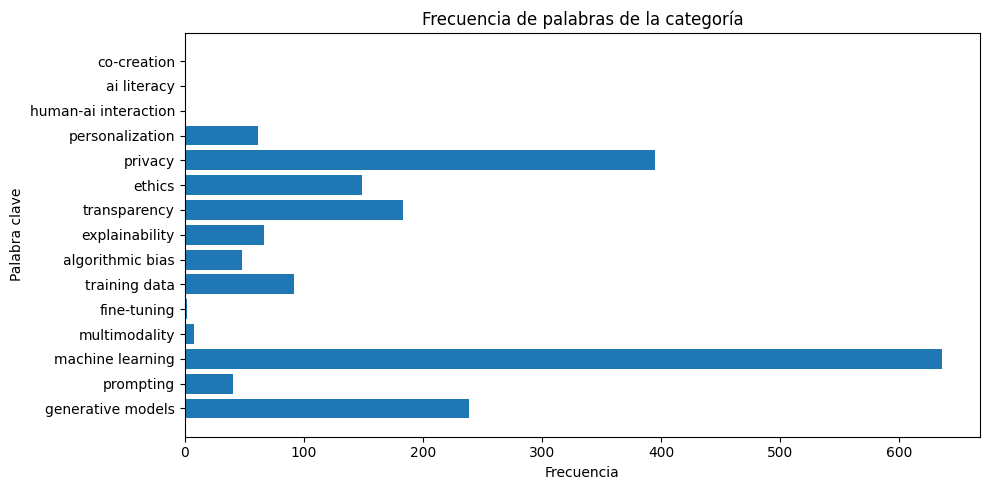

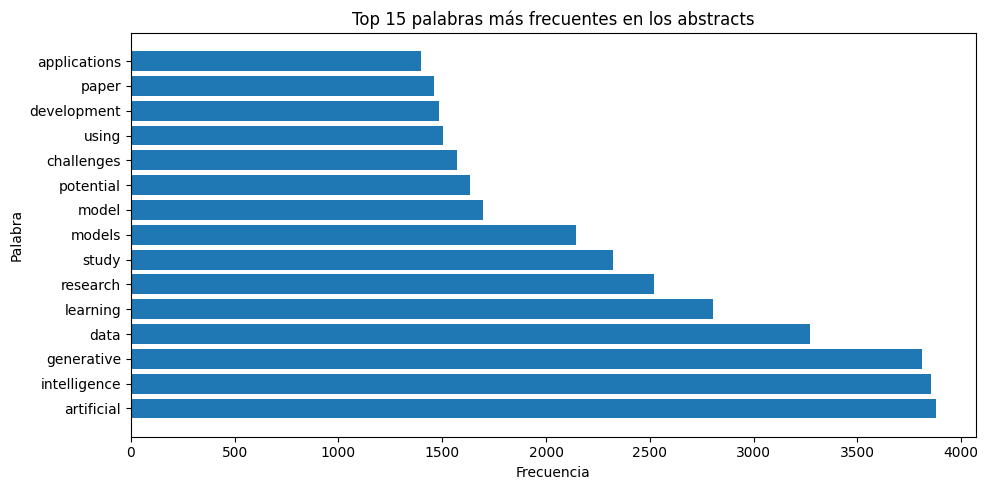

In [7]:
import os
import matplotlib.pyplot as plt

# Crear carpeta de salida si no existe
os.makedirs("resultados/graficos", exist_ok=True)

# --- Gráfico de las palabras de la categoría ---
plt.figure(figsize=(10, 5))
plt.barh(list(frecuencias_categoria.keys()), list(frecuencias_categoria.values()))
plt.title("Frecuencia de palabras de la categoría")
plt.xlabel("Frecuencia")
plt.ylabel("Palabra clave")
plt.tight_layout()  # Ajusta el diseño para evitar cortes
plt.savefig("frecuencia_palabras_categoria.png", dpi=300)
plt.show()

# --- Gráfico de las top 15 palabras ---
plt.figure(figsize=(10, 5))
palabras, freqs = zip(*top15)
plt.barh(palabras, freqs)
plt.title("Top 15 palabras más frecuentes en los abstracts")
plt.xlabel("Frecuencia")
plt.ylabel("Palabra")
plt.tight_layout()
plt.savefig("top15_palabras.png", dpi=300)
plt.show()
